In [3]:
repo_path = '/Users/JRyu/github/plinko_nn'

In [4]:
import sys
sys.path.append(repo_path + '/src')
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.distributions.normal import Normal

from plinko.misc import data_utils
from plinko.misc.simulation_dataset import SimulationDataset
from plinko.model.predictor_gru import GRUPredictor
from plinko.misc import plot as plinko_plot
from plinko.model.mlp import MLP
from plinko.misc import utils

from plotnine import * #ggplot, geom_point, aes, labs
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(0)
torch.manual_seed(0)
torch.set_default_tensor_type('torch.FloatTensor')
epsilon = sys.float_info.epsilon

df_ball = pd.read_feather(repo_path + '/data/simulations/sim_ball.feather')
df_env = pd.read_feather(repo_path + '/data/simulations/sim_environment.feather')
df_col = pd.read_feather(repo_path + '/data/simulations/sim_collisions.feather')

In [ ]:
collisions = df_col.copy()
collisions = collisions.rename({'object': 'collision'}, axis=1)
collisions.t -= 1

collisions = df_ball.merge(collisions, how='left')
#collisions = collisions[~collisions.collision.isna()]
collisions.collision[collisions.collision.isna()] = 'none'
collisions.collision[(collisions.collision == 'walls') & (collisions.px < 200)] = 'left_wall'
collisions.collision[(collisions.collision == 'walls') & (collisions.px > 500)] = 'right_wall'
collisions = collisions.groupby('collision', as_index=False).apply(lambda x: x.sample(2000))
collisions = collisions.sort_values(['simulation', 'run', 't'])


env_columns = ['triangle_x', 'triangle_y', 'triangle_r',
               'rectangle_x', 'rectangle_y', 'rectangle_r',
               'pentagon_x', 'pentagon_y','pentagon_r']
envs = collisions.merge(df_env).sort_values(['simulation', 'run', 't'])[env_columns]

idx2col = sorted(collisions.collision.unique())
col2idx = {c: i for c, i in zip(idx2col, range(len(idx2col)))}

states = torch.tensor(collisions[['px', 'py', 'vx', 'vy']].values, dtype=torch.float, device=device)
targets = torch.tensor([col2idx[c] for c in collisions.collision], dtype=torch.long, device=device)
envs = torch.tensor(envs.values, dtype=torch.float, device=device)

# old versions
df_envs2 = df_env.copy()
df_envs2['triangle_rsin'] = np.sin(df_env['triangle_r'])
df_envs2['triangle_rcos'] = np.cos(df_env['triangle_r'])
df_envs2['rectangle_rsin'] = np.sin(df_env['rectangle_r'])
df_envs2['rectangle_rcos'] = np.cos(df_env['rectangle_r'])
df_envs2['pentagon_rsin'] = np.sin(df_env['pentagon_r'])
df_envs2['pentagon_rcos'] = np.cos(df_env['pentagon_r'])

env_trig_columns = ['triangle_x', 'triangle_y', 'triangle_rsin','triangle_rcos',
               'rectangle_x', 'rectangle_y', 'rectangle_rsin','rectangle_rcos',
               'pentagon_x', 'pentagon_y','pentagon_rsin', 'pentagon_rcos']
envs_trig = collisions.merge(df_envs2).sort_values(['simulation', 'run', 't'])[env_trig_columns]

In [7]:
colls2_b1 = df_col.copy()
colls2_b1 = colls2_b1.rename({'object': 'collision'}, axis=1)
colls2_b1.t -= 1
colls2_b2 = colls2_b1.copy()
colls2_b3 = colls2_b2.copy()

colls2_b1 = df_ball.merge(colls2_b1, how='left')
colls2_b1 = colls2_b1.rename({'px': 'px_b1', 'py':'py_b1', 'vx':'vx_b1', 'vy':'vy_b1'}, axis=1)

colls2_b2 = df_ball.merge(colls2_b2, how='left')
colls2_b2 = colls2_b2.rename({'px': 'px_b2', 'py':'py_b2', 'vx':'vx_b2', 'vy':'vy_b2'}, axis=1)
colls2_b2.t += 1

colls2_b3 = df_ball.merge(colls2_b3, how='left')
colls2_b3 = colls2_b3.rename({'px': 'px_b3', 'py':'py_b3', 'vx':'vx_b3', 'vy':'vy_b3'}, axis=1)
colls2_b3.t += 2


colls2 = colls2_b1.merge(colls2_b2, left_on=['simulation','run','t'], right_on=['simulation','run','t'])
colls2 = colls2.merge(colls2_b3, left_on=['simulation','run','t'], right_on=['simulation','run','t'])
print(colls2_b1.head())
print(colls2_b2.head())
print(colls2.head())
colls2 = colls2.drop(columns=["collision_x", "collision_y"])

#collisions = collisions[~collisions.collision.isna()]
colls2.collision[colls2.collision.isna()] = 'none'
colls2.collision[(colls2.collision == 'walls') & (colls2.px_b1 < 200)] = 'left_wall'
colls2.collision[(colls2.collision == 'walls') & (colls2.px_b1 > 500)] = 'right_wall'
colls2 = colls2.groupby('collision', as_index=False).apply(lambda x: x.sample(2000))
colls2 = colls2.sort_values(['simulation', 'run', 't'])

env2_columns = ['triangle_x', 'triangle_y', 'triangle_r',
               'rectangle_x', 'rectangle_y', 'rectangle_r',
               'pentagon_x', 'pentagon_y','pentagon_r']
envs2 = colls2.merge(df_env).sort_values(['simulation', 'run', 't'])[env2_columns]

idx2col = sorted(colls2.collision.unique())
col2idx = {c: i for c, i in zip(idx2col, range(len(idx2col)))}

states2 = torch.tensor(colls2[['px_b1', 'py_b1', 'vx_b1', 'vy_b1', 'px_b2', 'py_b2', 'vx_b2', 'vy_b2','px_b3', 'py_b3', 'vx_b3', 'vy_b3']].values, dtype=torch.float, device=device)
targets2 = torch.tensor([col2idx[c] for c in colls2.collision], dtype=torch.long, device=device)
envs2 = torch.tensor(envs2.values, dtype=torch.float, device=device)



  simulation  run  t       px_b1       py_b1      vx_b1       vy_b1 collision
0      sim_0    0  0  178.155841  623.229729 -24.935251 -121.841279       NaN
1      sim_0    0  1  177.740254  621.042791 -24.935251 -146.841279       NaN
2      sim_0    0  2  177.324666  618.439186 -24.935251 -171.841279       NaN
3      sim_0    0  3  176.909078  615.418915 -24.935251 -196.841279       NaN
4      sim_0    0  4  176.493491  611.981977 -24.935251 -221.841279       NaN
  simulation  run  t       px_b2       py_b2      vx_b2       vy_b2 collision
0      sim_0    0  1  178.155841  623.229729 -24.935251 -121.841279       NaN
1      sim_0    0  2  177.740254  621.042791 -24.935251 -146.841279       NaN
2      sim_0    0  3  177.324666  618.439186 -24.935251 -171.841279       NaN
3      sim_0    0  4  176.909078  615.418915 -24.935251 -196.841279       NaN
4      sim_0    0  5  176.493491  611.981977 -24.935251 -221.841279       NaN
  simulation  run  t       px_b1       py_b1      vx_b1       vy

In [9]:
#print(colls2_b2.columns[:3])
#print(colls2_b2.columns[4:])
#print(colls2_b1)
#print(colls2_b3)
#print(df_ball)
#print(df_col)
#print(colls2_b1.shape)
#print(colls2.shape)
print(colls2.columns)
print(colls2.head())

print(targets2.dtype)
print(set(targets2.numpy()))

Index(['simulation', 'run', 't', 'px_b1', 'py_b1', 'vx_b1', 'vy_b1', 'px_b2',
       'py_b2', 'vx_b2', 'vy_b2', 'px_b3', 'py_b3', 'vx_b3', 'vy_b3',
       'collision'],
      dtype='object')
      simulation  run   t       px_b1       py_b1       vx_b1       vy_b1  \
1 353      sim_0    5  13  179.301542  561.573926    3.129059 -449.951033   
2 425      sim_0    6  19  197.698624  526.694349  225.365530  -81.070970   
  489      sim_0    7  18  180.185549  531.753160  174.946081  -62.933530   
1 504      sim_0    7  33  238.389288  509.383540  273.454854 -186.683477   
2 624      sim_0    9  18  175.965184  534.460424  160.422612  -57.708988   

            px_b2       py_b2       vx_b2       vy_b2       px_b3       py_b3  \
1 353  179.249391  568.812693    3.129059 -424.951033  179.197240  575.634793   
2 425  194.022753  528.008118  217.402697  -78.206492  191.177659  531.214661   
  489  177.306076  532.642530  166.983247  -60.069052  175.990118  537.461580   
1 504  233.831707  512

In [ ]:
model = MLP(input_size=[9, 4],
            hidden_layer_size=[48,48,48],
            activation=nn.ELU,
            output_size=len(idx2col)).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
epochs = 600

rows = []
for epoch in tqdm(range(epochs+1)):
    optimizer.zero_grad()
    outputs = model(envs, states)
    loss = F.cross_entropy(outputs, targets)
    loss.backward()
    optimizer.step()
    
    loss = float(loss)
    corrects = (outputs.argmax(-1) == targets).float()
    accuracy = float(corrects.mean())
    row = {'epoch': epoch, 'loss': loss, 'acc_total': accuracy}
    for idx in range(len(idx2col)):
        row['acc_' + idx2col[idx]] = float(corrects[targets == idx].mean())
    rows.append(row)
    if epoch%100 == 0:
        print(epoch, round(loss, 4), round(accuracy, 4))
        
summary = pd.DataFrame(rows)

In [8]:
model = MLP(input_size=[17, 4],
            hidden_layer_size=[48,48,48],
            activation=nn.ELU,
            output_size=len(idx2col)).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum = 0.1,dampening=0,weight_decay=0.001)
epochs = 1000

rows = []
for epoch in tqdm(range(epochs+1)):
    optimizer.zero_grad()
    outputs = model(envs2, states2)
    loss = F.cross_entropy(outputs, targets2)
    loss.backward()
    optimizer.step()
    
    loss = float(loss)
    corrects = (outputs.argmax(-1) == targets2).float()
    accuracy = float(corrects.mean())
    row = {'epoch': epoch, 'loss': loss, 'acc_total': accuracy}
    for idx in range(len(idx2col)):
        row['acc_' + idx2col[idx]] = float(corrects[targets2 == idx].mean())
    rows.append(row)
    if epoch%100 == 0:
        print(epoch, round(loss, 4), round(accuracy, 4))
        
summary = pd.DataFrame(rows)

0 42.9053 0.1824
100 0.6871 0.6917
200 0.6688 0.689
300 0.6876 0.6744
400 0.6685 0.6907
500 0.6674 0.6906
600 0.6667 0.6915
700 0.666 0.6912
800 0.6749 0.682
900 0.6648 0.6922
1000 0.6649 0.6852



In [11]:
print(outputs.argmax(-1).shape)
print(idx2col)
print(outputs.argmax(-1))
print(targets2)

torch.Size([12000])
['left_wall', 'none', 'pentagon', 'rectangle', 'right_wall', 'triangle']
tensor([1, 2, 2,  ..., 1, 1, 1])
tensor([1, 2, 2,  ..., 1, 1, 1])


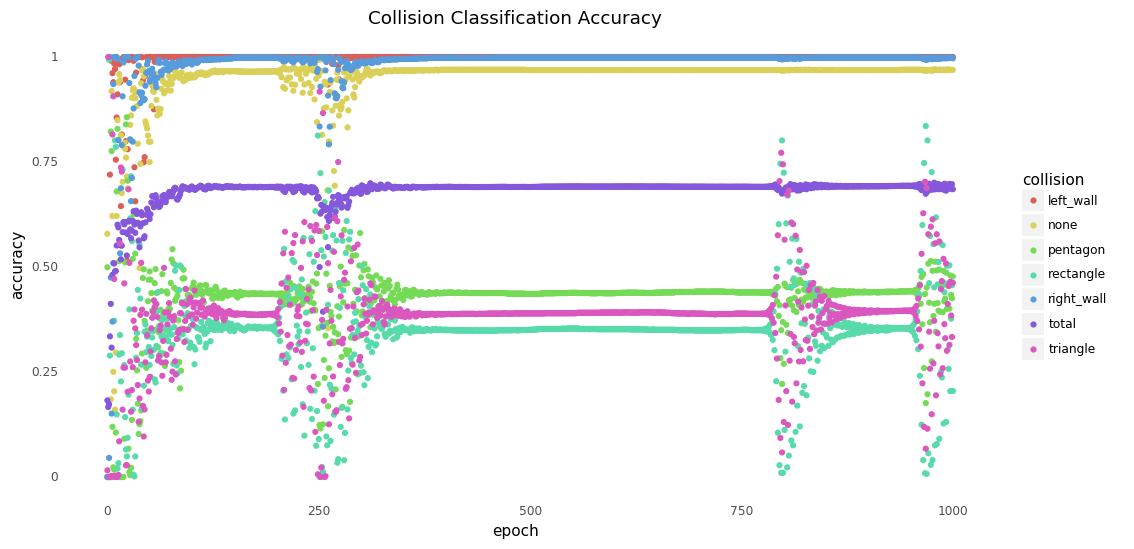

<ggplot: (7567514509)>

In [13]:
accuracies = summary.drop('loss', axis=1)
accuracies = pd.melt(accuracies, id_vars='epoch', var_name='collision')
accuracies.collision = [a[4:] for a in accuracies.collision]
accuracies = accuracies.rename({'value': 'accuracy'}, axis=1)

(ggplot(accuracies)
     + geom_point(aes(x='epoch', y='accuracy', color='collision'))
     + labs(title='Collision Classification Accuracy')
     + ylim(0, 1)
     + theme(
             figure_size=(12, 6),
             panel_background=element_blank(),
             line=element_blank(),
             panel_border=element_blank(),
            )
)

(6, 6)
['left_wall', 'none', 'pentagon', 'rectangle', 'right_wall', 'triangle']
[[1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [1.000e-03 9.695e-01 5.000e-04 0.000e+00 2.800e-02 1.000e-03]
 [0.000e+00 7.750e-02 4.775e-01 1.930e-01 7.000e-03 2.450e-01]
 [0.000e+00 6.400e-02 4.015e-01 2.050e-01 6.000e-03 3.235e-01]
 [0.000e+00 1.000e-03 5.000e-04 0.000e+00 9.970e-01 1.500e-03]
 [0.000e+00 5.150e-02 3.265e-01 1.400e-01 1.950e-02 4.625e-01]]


[None, None, None, None, None, None, None, None, None, None, None, None]

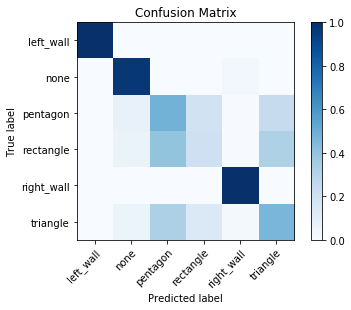

In [14]:
cm = confusion_matrix(targets2, outputs.argmax(-1))
print(cm.shape)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize
classes = idx2col
print(classes)

print(cm)
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=classes, yticklabels=classes,
       title='Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")